<a href="https://colab.research.google.com/github/kauanunnes/visao-computacional-pjbl/blob/main/pjbl_visao_computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

url = "https://github.com/kauanunnes/visao-computacional-pjbl/raw/refs/heads/main/archive.zip"
zip_path = "archive.zip"
extract_path = "dataset"

print("Baixando dataset...")
response = requests.get(url)
with open(zip_path, "wb") as f:
    f.write(response.content)

print("Extraindo arquivos...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

Baixando dataset...
Extraindo arquivos...
Arquivos extraídos com sucesso!
Diretório de treino: dataset/train
Diretório de teste: dataset/test


In [2]:
base_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 570 images belonging to 3 classes.
Found 141 images belonging to 3 classes.


In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # primeiro congela o modelo

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.3569 - loss: 1.3377 - val_accuracy: 0.6028 - val_loss: 0.9051 - learning_rate: 5.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step - accuracy: 0.6108 - loss: 0.8705 - val_accuracy: 0.6950 - val_loss: 0.7329 - learning_rate: 5.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 577ms/step - accuracy: 0.6658 - loss: 0.7664 - val_accuracy: 0.7447 - val_loss: 0.7078 - learning_rate: 5.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 478ms/step - accuracy: 0.7227 - loss: 0.6501 - val_accuracy: 0.7376 - val_loss: 0.6619 - learning_rate: 5.0000e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 529ms/step - accuracy: 0.7479 - loss: 0.5982 - val_accuracy: 0.7730 - val_loss: 0.6556 - learning_rate: 5.0000e-04
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 527ms/step - accuracy: 0.7769 - loss: 0.5587 - val_accuracy: 0.6454 - val_loss: 0.6951 - learning_rate: 5.0000e-04
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 525ms/step - accuracy: 

In [5]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 40  # descongela últimas 40 camadas

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6879 - loss: 0.6894 - val_accuracy: 0.8014 - val_loss: 0.5624 - learning_rate: 1.0000e-05
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 490ms/step - accuracy: 0.7308 - loss: 0.6339 - val_accuracy: 0.7730 - val_loss: 0.5536 - learning_rate: 1.0000e-05
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 511ms/step - accuracy: 0.7276 - loss: 0.6285 - val_accuracy: 0.7447 - val_loss: 0.6657 - learning_rate: 1.0000e-05
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 533ms/step - accuracy: 0.8014 - loss: 0.5533 - val_accuracy: 0.7163 - val_loss: 0.6365 - learning_rate: 1.0000e-05
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 537ms/step - accuracy: 0.7067 - loss: 0.6354 - val_accuracy: 0.7518 - val_loss: 0.5927 - learning_rate: 1.0000e-05
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step - accuracy: 0.8164 - loss: 0.4799 - val_accuracy: 0.7589 - val_loss: 0.6152 - learning_rate: 2.0000e-06
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 477ms/step - accuracy: 

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Acurácia no conjunto de teste: {test_acc*100:.2f}%")

Found 114 images belonging to 3 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8089 - loss: 0.5052

✅ Acurácia no conjunto de teste: 79.82%


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step

Relatório de Classificação:

              precision    recall  f1-score   support

      adidas       0.81      0.79      0.80        38
    converse       0.77      0.95      0.85        38
        nike       0.83      0.66      0.74        38

    accuracy                           0.80       114
   macro avg       0.80      0.80      0.79       114
weighted avg       0.80      0.80      0.79       114



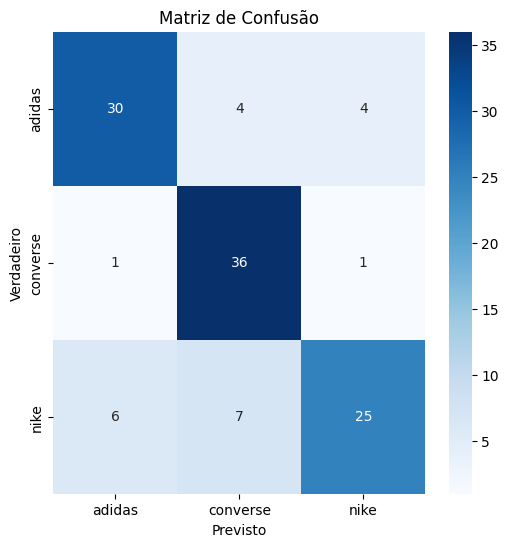

In [7]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('\nRelatório de Classificação:\n')
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title("Matriz de Confusão")
plt.ylabel("Verdadeiro")
plt.xlabel("Previsto")
plt.show()

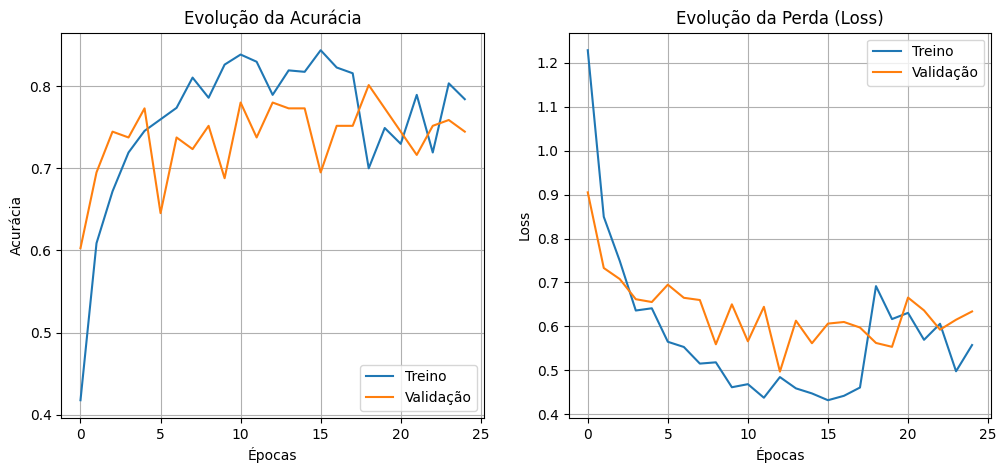

In [8]:
acc = history.history['accuracy'] + fine_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_history.history['val_accuracy']
loss = history.history['loss'] + fine_history.history['loss']
val_loss = history.history['val_loss'] + fine_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# --- Acurácia ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')
plt.grid(True)

# --- Perda ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino')
plt.plot(epochs_range, val_loss, label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()
